:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`quickstart.ipynb`**!

:::

(quickstart-nb)=
# Quickstart

The following tutorial is intended to show you how to create a simple `plenoptic`-compliant model and use it with our synthesis methods, with a brief explanation of how to interpret the outputs. See the other tutorials for more details.

In [1]:
import matplotlib.pyplot as plt
import torch

import plenoptic as po

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72


plt.rcParams["animation.html"] = "html5"
# use single-threaded ffmpeg for animation writer
plt.rcParams["animation.writer"] = "ffmpeg"
plt.rcParams["animation.ffmpeg_args"] = ["-threads", "1"]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

All `plenoptic` methods require a "reference" or "target" image --- for Metamer synthesis, for example, this is the image whose representation we will match. Let's load in an image of Einstein to serve as our reference here:

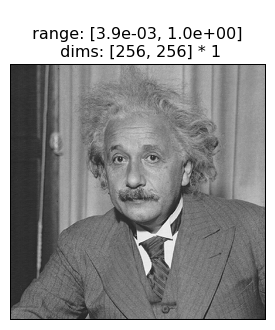

In [2]:
im = po.data.einstein().to(DEVICE)
fig = po.imshow(im)

Models can be really simple, as this demonstrates. It needs to inherit {class}`torch.nn.Module` and just needs two methods: `__init__` (so it's an object) and `forward` <!-- skip-lint --> (so it can take an image). See the [Models page](models-doc) of the documentation for more details.

For this notebook, we'll initialize a simple plenoptic-compatible model and call its forward method. This model just convolves a 2d gaussian filter across an image, so it's a low-pass model, preserving low frequency information while discarding the high frequencies.

In [3]:
# this is a convenience function for creating a simple Gaussian kernel
from plenoptic.simulate.canonical_computations.filters import (
    circular_gaussian2d,
)


# Simple rectified Gaussian convolutional model
class SimpleModel(torch.nn.Module):
    # in __init__, we create the object, initializing the convolutional weights and
    # nonlinearity
    def __init__(self, kernel_size=(7, 7)):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = torch.nn.Conv2d(
            1, 1, kernel_size=kernel_size, padding=(0, 0), bias=False
        )
        self.conv.weight.data[0, 0] = circular_gaussian2d(kernel_size, 3.0)

    # the forward pass of the model defines how to get from an image to the model's
    # representation
    def forward(self, x):
        # use circular padding so our output is the same size as our input
        x = po.tools.conv.same_padding(x, self.kernel_size, pad_mode="circular")
        return self.conv(x)


model = SimpleModel()
model.eval()
model.to(DEVICE)
rep = model(im)

To work with out synthesis methods, a model must accept a tensor as input and return a tensor as output. In pytorch, images are generally represented as 4d tensors, and the dimensions are batch (often, multiple images), channel (often, RGB or outputs of different convolutional filters), height, and width. The models included in `plenoptic` typically accept a 4d image tensor and return a tensor with a 3 (`batch, channel, vector`) or 4 (`batch, channel, height, width`) dimensions. While our synthesis methods work with models that operate on tensors of different dimensionality, models which follow this behavior have been tested most extensively.

We can see that our Gaussian model satisfies this constraint:

In [4]:
print(im.shape)
print(rep.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


There are also several more abstract constraints (e.g., model must accept real-valued inputs and return real-valued outputs), so it's recommended that you read the [Models page](models-doc) of the documentation before creating your own model.

The following shows the image and the model output. We can see that output is a blurred version of the input, as we would expect from a low-pass model.

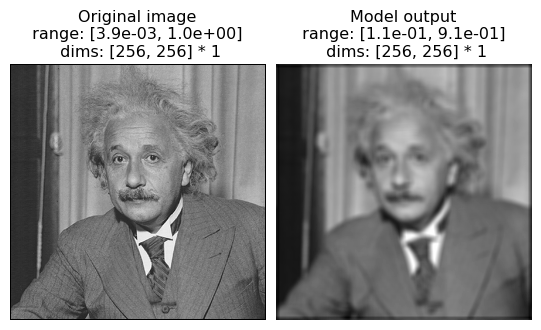

In [5]:
fig = po.imshow(torch.cat([im, rep]), title=["Original image", "Model output"])

Before moving forward, let's think about this model. It's a simple Gaussian convolution which throws out high-frequency information, as we can see in the representation above. Metamers provide a tool for exploring a model's insensitivities, so any metamers we synthesize should capitalize on this: they should differ from the original image in the high frequencies.

There's one final step before we're ready for synthesis. Most `pytorch` models will have learnable parameters, such as the weight on the convolution filter we created above, because the focus is generally on training the model to best perform some task. In `plenoptic`, models are *fixed* because we take the opposite approach: generating some new stimulus to better a understand a given model. Thus, all synthesis methods will raise a `ValueError` if given a model with any learnable parameters. We provide a helper function to remove these gradients:

In [6]:
po.tools.remove_grad(model)

Okay, now we're ready to start with metamer synthesis. To initialize, we only need the model and the image (there are some additional options, but the defaults are fine in this case; see the [Metamer notebook](metamer-nb) if you're interested). In general, you'll probably need to play with these options to find a good solution. It's also probably a good idea, while getting started, to set the `store_progress` argument to `True` (to store every iteration) or some `int` (to store every `int` iterations) so you can examine synthesis progress.

In [7]:
metamer = po.synth.Metamer(im, model)

matched_im = metamer.synthesize(store_progress=True, max_iter=20)
# if we call synthesize again, we resume where we left off
matched_im = metamer.synthesize(store_progress=True, max_iter=150)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

/home/agent/workspace/neurorse_plenoptic_main@2/lib/python3.11/site-packages/plenoptic/synthesize/metamer.py:367: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


We can then examine the loss over time. There's a convenience function for this, but you could also call `plt.semilogy(metamer.losses)` to create it yourself.

<Axes: xlabel='Synthesis iteration', ylabel='Loss'>

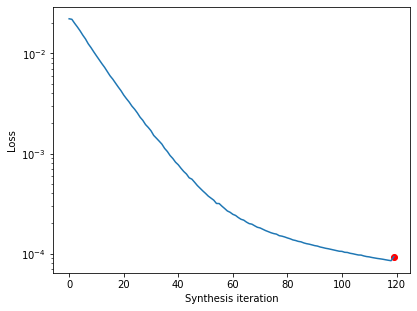

In [8]:
po.synth.metamer.plot_loss(metamer)

The loss decreases steadily and has reached a very low value. In fact, based on our convergence criterion (one of the optional arguments), it looks as though we've converged (we could change this argument to continue synthesis).

We can then look at the reference and metamer images, as well as the model's outputs on the two images:

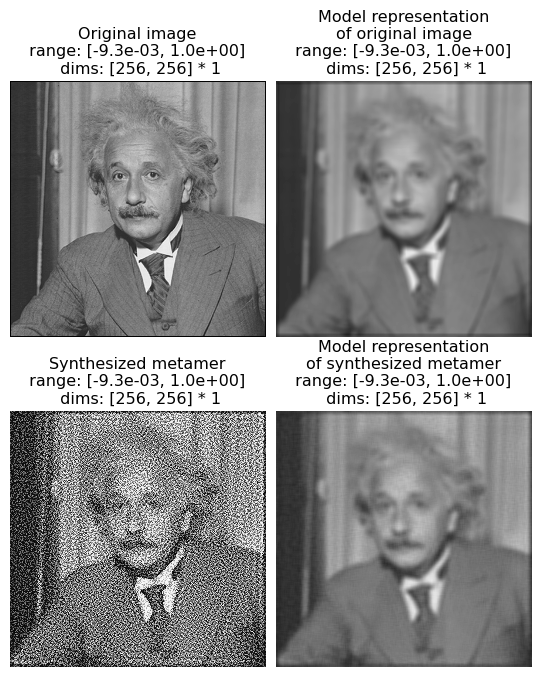

In [9]:
fig = po.imshow(
    [im, rep, metamer.metamer, model(metamer.metamer)],
    col_wrap=2,
    vrange="auto1",
    title=[
        "Original image",
        "Model representation\nof original image",
        "Synthesized metamer",
        "Model representation\nof synthesized metamer",
    ],
)

We can see that, even though the target and synthesized images look very different, the two model outputs look basically identical (which matches the exceedingly low loss value we see above). (The left column shows the images and the right column the model outputs; top row shows the original image and bottom the synthesized metamer.)

It may seem strange that the synthesized image looks like it has high-frequency noise in it --- a Gaussian is a low-pass filter, so why isn't the model metamer just a blurred version of the original image? Indeed, such a blurred image would be a model metamer, but it's only one of many. Remember what we mentioned earlier: Gaussians are insensitive to high-frequency information, which not only means that their response doesn't change when you remove that information, but that you can put any amount of high frequency information into an image without affecting the model's output. Put another way, you can randomize the contents of the model's null space without affecting its response, and the goal of metamer synthesis is to generate different images that do just that.

We can also view a movie of our progress so far.

In [10]:
po.synth.metamer.animate(
    metamer, included_plots=["display_metamer", "plot_loss"], figsize=(12, 5)
)

We can see the model's insensitivity to high frequencies more dramatically by initializing our metamer synthesis with a different image. By default, we initialize with a patch of white noise, but we can initialize with any image of the same size. Let's try with a different natural image, a picture of Marie Curie.

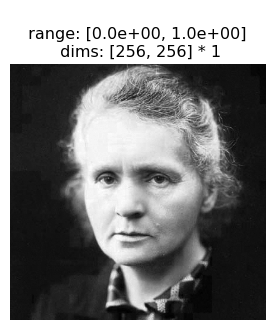

In [11]:
curie = po.data.curie().to(DEVICE)
po.imshow(curie);

In [12]:
metamer = po.synthesize.Metamer(
    im,
    model,
)
metamer.setup(initial_image=curie)

# we increase the length of time we run synthesis and decrease the
# stop_criterion, which determines when we think loss has converged
# for stopping synthesis early.
synth_image = metamer.synthesize(max_iter=500, stop_criterion=1e-6)

  0%|          | 0/500 [00:00<?, ?it/s]

/home/agent/workspace/neurorse_plenoptic_main@2/lib/python3.11/site-packages/plenoptic/synthesize/metamer.py:367: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


Let's double-check that our synthesis looks like it's reached a good solution by checking the loss curve:

<Axes: xlabel='Synthesis iteration', ylabel='Loss'>

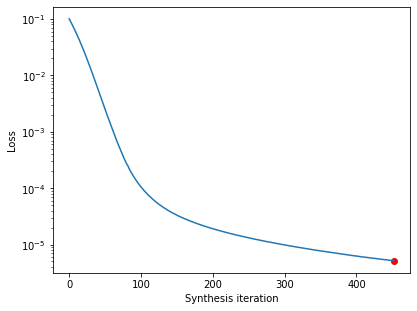

In [13]:
po.synth.metamer.plot_loss(metamer)

Good, now let's examine our synthesized metamer and the model output, as before:

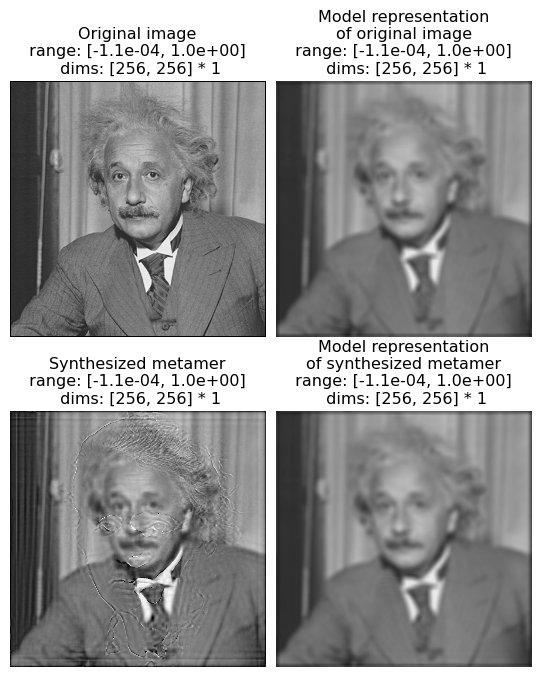

In [14]:
fig = po.imshow(
    [im, rep, metamer.metamer, model(metamer.metamer)],
    col_wrap=2,
    vrange="auto1",
    title=[
        "Original image",
        "Model representation\nof original image",
        "Synthesized metamer",
        "Model representation\nof synthesized metamer",
    ],
)

We see that the synthesized metamer here looks quite different from both the original and from our previous metamer, while the model outputs look very similar. Here, our synthesized model metamer looks like a blurry picture of Einstein with a high-frequency "shadow" of Curie added on top. Again, this is because the Gaussian model is insensitive to high frequencies, and thus a model metamer can include any high frequency information.

By generating model metamers, we've gained a better understanding of the information our model is invariant to, but what if we want a better understanding of what our model is sensitive to? We can use {class}`~plenoptic.synthesize.eigendistortion.Eigendistortion` for that.

Like {class}`~plenoptic.synthesize.metamer.Metamer`, {class}`~plenoptic.synthesize.eigendistortion.Eigendistortion` accepts an image and a model as its inputs. By default, it synthesizes the top and bottom eigendistortion, that is, the changes to the input image that the model finds most and least noticeable.

In [15]:
eig = po.synthesize.Eigendistortion(im, model)
eig.synthesize()

Top k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Bottom k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Let's examine those distortions:

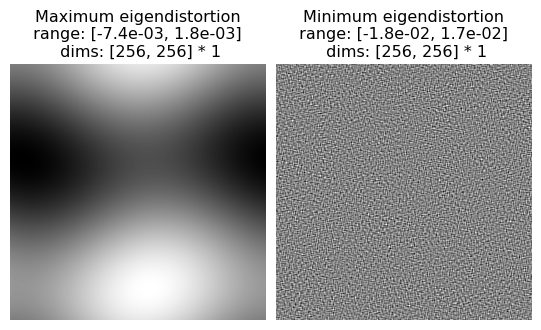

In [16]:
po.imshow(
    eig.eigendistortions,
    title=["Maximum eigendistortion", "Minimum eigendistortion"],
);

We can see they make sense: the most noticeable distortion is a very low-frequency modification to the image, with a period of about half the image. The least noticeable, on the other hand, is very high-frequency, which matches our understanding from the metamer example above.

This brief introduction hopefully demonstrates how you can use plenoptic to better understand your model representations!